In [ ]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 13.7MB/s 
     |████████████████████████████████| 9.5MB 54.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import numpy as np
import math
import re
import os
from sklearn.impute import KNNImputer
from sklearn.metrics import r2_score
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
#import pmdarima as pmd
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
pd.options.mode.chained_assignment = None 

# Data Pre-Processing

In [ ]:
dataframe = pd.read_excel('/content/drive/MyDrive/AdvanceML/dataset/04-10 February 2021.xlsx',sheet_name="Weekly ET",usecols='A:L')
#dataframe.columns = ['Location','Crop_Coefficient','Day_1','Day_2','Day_3','Day_4','Day_5','Day_6','Day_7','Total_ETo','Precipitation','Irrigation_Required']

In [ ]:
dataframe

,Location,Crop Coefficient (Kc),2021-02-04 00:00:00,2021-02-05 00:00:00,2021-02-06 00:00:00,2021-02-07 00:00:00,2021-02-08 00:00:00,2021-02-09 00:00:00,2021-02-10 00:00:00,Total (mm),Precipitation (mm),Net Weekly Irrigation Requirement (mm)
0,3 Sialkot District,Maize = 0.9,1.260000,1.080000,1.200000,1.440,1.440000,1.620000,1.500000,9.540000,0,12.402000
1,NaN,Rice = 1.12,1.568000,1.344000,1.493333,1.792,1.792000,2.016000,1.866667,11.872000,0,15.433600
2,NaN,Wheat =0.78,1.092000,0.936000,1.040000,1.248,1.248000,1.404000,1.300000,8.268000,0,10.748400
3,NaN,Sugarcane = 0.44,0.616000,0.528000,0.586667,0.704,0.704000,0.792000,0.733333,4.664000,0,6.063200
4,4 Gujrat District,Wheat = 0.78,1.040000,0.832000,0.884000,1.144,1.300000,1.352000,1.248000,7.800000,0,10.140000
...,...,...,...,...,...,...,...,...,...,...,...,...
110,43 Pakpatan,Maize(Hybrid = 1.54,0.858000,0.650000,0.598000,0.702,0.832000,1.040000,0.884000,5.564000,0,7.233200
111,NaN,Rice = 1.12,0.858000,0.650000,0.598000,0.702,0.832000,1.040000,0.884000,5.564000,0,7.233200
112,NaN,Sugarcane = 0.44,0.968000,0.733333,0.674667,0.792,0.938667,1.173333,0.997333,6.277333,0,8.160533
113,44 Vehari,Cotton = 0.49,0.988000,0.728000,0.650000,0.858,0.936000,1.144000,1.066000,6.370000,0,8.281000


In [ ]:
#clean the string
def clean(s):
  s = s.replace("\n","")
  s = re.sub(r"[!@#$%^&*()_\-\+=\[\]{};'\"/?.\\.,><:~`]|[0-9]","",s)
  s.lower()
  s=s.strip(' ')
  return s

In [ ]:
#use to clean crop_name
def clean_2(s):
  s = s.replace(" ","")
  s=s.strip(' ')
  return s


In [ ]:
def Pre_Processor(dataframe):
  dataframe.columns = ['Location','Crop_Coefficient','Day_1','Day_2','Day_3','Day_4','Day_5','Day_6','Day_7','Total_ETo','Precipitation','Irrigation_Required']
  #filling the missing values
  dataframe['Location']=dataframe['Location'].replace(to_replace =np.NaN,value ="x_x")
  temp=""
  index=0
  for row in dataframe['Location']:
    if row == "x_x":
      dataframe['Location'][index]=dataframe['Location'][index].replace("x_x",temp)
    else:
      temp=dataframe['Location'][index]
    index = index+1

  #creating new column
  dataframe['Crop_Name']='crop'

  #settingthe crop_Coefficient
  index=0
  for row in dataframe['Crop_Coefficient']:
    list_ = row.split('=')
    list_[0] #send to crop name
    dataframe['Crop_Name'][index]=dataframe['Crop_Name'][index].replace("crop",list_[0])
    list_[1] #send to Crop_Coefficient
    dataframe['Crop_Coefficient'][index]=dataframe['Crop_Coefficient'][index].replace(row,list_[1])
    
    list_=""#clear the list
    index=index+1
    
  #type_casting
  dataframe=dataframe.astype({'Crop_Coefficient': 'float64'})

  #cleaning location
  index=0
  for row in dataframe['Location']:
    clean_string = clean(row)
    dataframe['Location'][index]=dataframe['Location'][index].replace(row,clean_string)
    index=index+1

  #cleaning crop_name with clean
  index=0
  for row in dataframe['Crop_Name']:
    clean_string = clean(row)
    dataframe['Crop_Name'][index]=dataframe['Crop_Name'][index].replace(row,clean_string)
    index=index+1


  #cleaning crop_name with clean_2
  index=0
  for row in dataframe['Crop_Name']:
    clean_string = clean_2(row)
    dataframe['Crop_Name'][index]=dataframe['Crop_Name'][index].replace(row,clean_string)
    index=index+1

  #replacing value
  dataframe['Crop_Name']=dataframe['Crop_Name'].replace(to_replace ="MaizeHybrid",value ="Maize")
  dataframe['Location']=dataframe['Location'].replace(to_replace ="Islamabd",value ="Islamabad")

  return dataframe

In [ ]:
#main aggregator
def Aggregator_(path): #Function to create single document of all files
  flag = True
  for subdir, dirs, files in os.walk(path):
      for filename in files:
          filepath=""
          filepath = subdir + os.sep + filename
          #print(filepath)
          if flag == True:
            dataframe = pd.read_excel(filepath,sheet_name="Weekly ET",usecols='A:L')
            mainData= Pre_Processor(dataframe)
            flag = False
          else:
            dataframe = pd.read_excel(filepath,sheet_name="Weekly ET",usecols='A:L')
            dataframe_cleaned = Pre_Processor(dataframe)
            mainData = pd.concat([mainData,dataframe_cleaned], axis=0)
  return mainData
          

In [ ]:
mainData = Aggregator_('/content/drive/MyDrive/AdvanceML/dataset')

In [ ]:
df = mainData.sort_values(by = 'Location')

In [ ]:
df = mainData

In [ ]:
df[103:120]

,Location,Crop_Coefficient,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Total_ETo,Precipitation,Irrigation_Required,Crop_Name
103,Pakpatan,1.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sugarcane
0,Sialkot District,0.60,2.666667,2.133333,2.240000,2.400000,2.453333,2.560000,2.506667,16.960000,31.875,-19.389500,Maize
1,Sialkot District,1.10,4.100000,3.280000,3.444000,3.690000,3.772000,3.936000,3.854000,26.076000,31.875,-7.538700,Rice
2,Sialkot District,1.00,3.333333,2.666667,2.800000,3.000000,3.066667,3.200000,3.133333,21.200000,31.875,-13.877500,Wheat
3,Sialkot District,1.17,3.666667,2.933333,3.080000,3.300000,3.373333,3.520000,3.446667,23.320000,31.875,-11.121500,Sugarcane
4,Gujrat District,1.00,3.866667,4.000000,3.466667,3.400000,3.466667,3.666667,3.666667,25.533333,25.800,-0.346667,Wheat
5,Gujrat District,1.10,4.756000,4.920000,4.264000,4.182000,4.264000,4.510000,4.510000,31.406000,25.800,7.287800,Rice
6,Gujrat District,1.17,4.253333,4.400000,3.813333,3.740000,3.813333,4.033333,4.033333,28.086667,25.800,2.972667,Sugarcane
7,Gujranwala District,1.00,4.200000,3.733333,3.600000,3.666667,3.733333,3.733333,3.733333,26.400000,75.450,-63.765000,Wheat
8,Gujranwala District,1.10,5.166000,4.592000,4.428000,4.510000,4.592000,4.592000,4.592000,32.472000,75.450,-55.871400,Rice


In [ ]:
#converting zero values to NaN
df['Crop_Coefficient']=df['Crop_Coefficient'].replace(to_replace =0,value =np.NaN)
df['Day_1']=df['Day_1'].replace(to_replace =0,value =np.NaN)
df['Day_2']=df['Day_2'].replace(to_replace =0,value =np.NaN)
df['Day_3']=df['Day_3'].replace(to_replace =0,value =np.NaN)
df['Day_4']=df['Day_4'].replace(to_replace =0,value =np.NaN)
df['Day_5']=df['Day_5'].replace(to_replace =0,value =np.NaN)
df['Day_6']=df['Day_6'].replace(to_replace =0,value =np.NaN)
df['Day_7']=df['Day_7'].replace(to_replace =0,value =np.NaN)
df['Total_ETo']=df['Total_ETo'].replace(to_replace =0,value =np.NaN)
df['Precipitation']=df['Precipitation'].replace(to_replace =0,value =np.NaN)
df['Irrigation_Required']=df['Irrigation_Required'].replace(to_replace =0,value =np.NaN)


In [ ]:
df.groupby(['Location']).sum()

,Crop_Coefficient,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Total_ETo,Precipitation,Irrigation_Required
Location,,,,,,,,,,,
Attock,58.810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
Bahawalnagar District,76.890,112.920000,110.529333,109.073333,112.656000,110.978667,110.835333,108.074667,775.067333,274.500,650.737533
Bahawalpur District,57.980,194.855333,188.345333,180.367333,192.066000,187.591333,191.343267,188.987333,1323.555933,253.575,1390.975213
Bhakkar,58.740,12.320000,11.200000,11.200000,12.320000,12.600000,11.900000,11.900000,83.440000,27.000,73.372000
Chakwal,58.810,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000
Chiniot,58.810,11.480000,7.140000,7.700000,10.080000,10.220000,10.500000,10.500000,67.620000,0.000,87.906000
DG Khan District,73.410,51.446000,50.916000,54.154000,49.659333,47.965267,49.952000,51.965333,356.057933,139.950,280.940313
Faisalabad District,67.290,148.905333,144.019333,143.798667,153.538000,140.952667,140.048000,139.661333,1010.923333,447.375,732.612833
Gujranwala District,76.540,169.407733,160.882000,164.252000,164.125333,151.641333,149.138667,149.842000,1109.289067,791.550,413.060787


In [ ]:
df = df[df.Location !=  'Attock' ]
df = df[df.Location !=  'Chakwal' ]
df = df[df.Location !=  'Islamabad' ]
df = df[df.Location !=  'Jaffarabad' ]
df = df[df.Location !=  'Naseerabad' ]

In [ ]:
df.to_csv('/content/drive/MyDrive/AdvanceML/main_cleaned.csv', index = False, header=True)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AdvanceML/main_cleaned.csv',sep = ',')

In [ ]:
df.isnull().sum()

Location                  0
Crop_Coefficient          0
Day_1                  1144
Day_2                  1144
Day_3                  1144
Day_4                  1144
Day_5                  1182
Day_6                  1182
Day_7                  1182
Total_ETo              1144
Precipitation          2593
Irrigation_Required    1144
Crop_Name                 0
dtype: int64

In [ ]:
df

,Location,Crop_Coefficient,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Total_ETo,Precipitation,Irrigation_Required,Crop_Name
0,Bahawalnagar District,1.54,0.754000,1.040000,1.040000,0.780000,0.650000,0.572000,0.624000,5.460000,NaN,7.098000,Maize
1,Bahawalnagar District,0.31,1.240000,1.240000,1.054000,1.033333,1.116000,1.178000,1.136667,7.998000,NaN,10.397400,Sugarcane
2,Bahawalnagar District,1.54,1.560000,1.560000,1.326000,1.300000,1.404000,1.482000,1.430000,10.062000,NaN,13.080600,Maize
3,Bahawalnagar District,0.68,1.314667,1.813333,1.813333,1.360000,1.133333,0.997333,1.088000,9.520000,NaN,12.376000,Sugarcane
4,Bahawalnagar District,1.19,2.106000,1.820000,1.872000,1.872000,2.028000,2.054000,2.080000,13.832000,NaN,17.981600,Maize
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952,Vehari,0.49,0.650000,0.728000,0.728000,0.728000,0.624000,0.546000,0.520000,4.524000,NaN,5.881200,Cotton
2953,Vehari,0.68,1.133333,1.269333,1.269333,1.269333,1.088000,0.952000,0.906667,7.888000,NaN,10.254400,Sugarcane
2954,Vehari,0.49,0.832000,0.728000,0.624000,0.936000,0.910000,0.702000,0.546000,5.278000,NaN,6.861400,Cotton
2955,Vehari,0.49,0.624000,0.962000,1.066000,0.806000,0.650000,0.546000,0.572000,5.226000,NaN,6.793800,Cotton


#Missing Values Imputation

In [ ]:
df.isnull().sum()

Location                  0
Crop_Coefficient          0
Day_1                  1144
Day_2                  1144
Day_3                  1144
Day_4                  1144
Day_5                  1182
Day_6                  1182
Day_7                  1182
Total_ETo              1144
Precipitation          2593
Irrigation_Required    1144
Crop_Name                 0
dtype: int64

In [ ]:
df2 = df[['Location', 'Crop_Name']].copy()
df2

,Location,Crop_Name
0,Bahawalnagar District,Maize
1,Bahawalnagar District,Sugarcane
2,Bahawalnagar District,Maize
3,Bahawalnagar District,Sugarcane
4,Bahawalnagar District,Maize
...,...,...
2952,Vehari,Cotton
2953,Vehari,Sugarcane
2954,Vehari,Cotton
2955,Vehari,Cotton


In [ ]:
df = df.drop(columns=['Location', 'Crop_Name'])
df

,Crop_Coefficient,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Total_ETo,Precipitation,Irrigation_Required
0,1.54,0.754000,1.040000,1.040000,0.780000,0.650000,0.572000,0.624000,5.460000,NaN,7.098000
1,0.31,1.240000,1.240000,1.054000,1.033333,1.116000,1.178000,1.136667,7.998000,NaN,10.397400
2,1.54,1.560000,1.560000,1.326000,1.300000,1.404000,1.482000,1.430000,10.062000,NaN,13.080600
3,0.68,1.314667,1.813333,1.813333,1.360000,1.133333,0.997333,1.088000,9.520000,NaN,12.376000
4,1.19,2.106000,1.820000,1.872000,1.872000,2.028000,2.054000,2.080000,13.832000,NaN,17.981600
...,...,...,...,...,...,...,...,...,...,...,...
2952,0.49,0.650000,0.728000,0.728000,0.728000,0.624000,0.546000,0.520000,4.524000,NaN,5.881200
2953,0.68,1.133333,1.269333,1.269333,1.269333,1.088000,0.952000,0.906667,7.888000,NaN,10.254400
2954,0.49,0.832000,0.728000,0.624000,0.936000,0.910000,0.702000,0.546000,5.278000,NaN,6.861400
2955,0.49,0.624000,0.962000,1.066000,0.806000,0.650000,0.546000,0.572000,5.226000,NaN,6.793800


In [ ]:
imputer = KNNImputer(n_neighbors=5)
# fit on the dataset
imputer.fit(df)
# transform the dataset
trans = imputer.transform(df)

In [ ]:
df = pd.DataFrame(trans)
df.columns = ['Crop_Coefficient','Day_1','Day_2','Day_3','Day_4','Day_5','Day_6','Day_7','Total_ETo','Precipitation','Irrigation_Required']

In [ ]:
df

,Crop_Coefficient,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Total_ETo,Precipitation,Irrigation_Required
0,1.54,0.754000,1.040000,1.040000,0.780000,0.650000,0.572000,0.624000,5.460000,0.630,7.098000
1,0.31,1.240000,1.240000,1.054000,1.033333,1.116000,1.178000,1.136667,7.998000,1.275,10.397400
2,1.54,1.560000,1.560000,1.326000,1.300000,1.404000,1.482000,1.430000,10.062000,1.110,13.080600
3,0.68,1.314667,1.813333,1.813333,1.360000,1.133333,0.997333,1.088000,9.520000,0.885,12.376000
4,1.19,2.106000,1.820000,1.872000,1.872000,2.028000,2.054000,2.080000,13.832000,0.630,17.981600
...,...,...,...,...,...,...,...,...,...,...,...
2952,0.49,0.650000,0.728000,0.728000,0.728000,0.624000,0.546000,0.520000,4.524000,0.525,5.881200
2953,0.68,1.133333,1.269333,1.269333,1.269333,1.088000,0.952000,0.906667,7.888000,1.275,10.254400
2954,0.49,0.832000,0.728000,0.624000,0.936000,0.910000,0.702000,0.546000,5.278000,0.570,6.861400
2955,0.49,0.624000,0.962000,1.066000,0.806000,0.650000,0.546000,0.572000,5.226000,0.720,6.793800


In [ ]:
df2

,Location,Crop_Name
0,Bahawalnagar District,Maize
1,Bahawalnagar District,Sugarcane
2,Bahawalnagar District,Maize
3,Bahawalnagar District,Sugarcane
4,Bahawalnagar District,Maize
...,...,...
2952,Vehari,Cotton
2953,Vehari,Sugarcane
2954,Vehari,Cotton
2955,Vehari,Cotton


In [ ]:
df = pd.concat([df2,df], axis=1)
df

,Location,Crop_Name,Crop_Coefficient,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Total_ETo,Precipitation,Irrigation_Required
0,Bahawalnagar District,Maize,1.54,0.754000,1.040000,1.040000,0.780000,0.650000,0.572000,0.624000,5.460000,0.630,7.098000
1,Bahawalnagar District,Sugarcane,0.31,1.240000,1.240000,1.054000,1.033333,1.116000,1.178000,1.136667,7.998000,1.275,10.397400
2,Bahawalnagar District,Maize,1.54,1.560000,1.560000,1.326000,1.300000,1.404000,1.482000,1.430000,10.062000,1.110,13.080600
3,Bahawalnagar District,Sugarcane,0.68,1.314667,1.813333,1.813333,1.360000,1.133333,0.997333,1.088000,9.520000,0.885,12.376000
4,Bahawalnagar District,Maize,1.19,2.106000,1.820000,1.872000,1.872000,2.028000,2.054000,2.080000,13.832000,0.630,17.981600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952,Vehari,Cotton,0.49,0.650000,0.728000,0.728000,0.728000,0.624000,0.546000,0.520000,4.524000,0.525,5.881200
2953,Vehari,Sugarcane,0.68,1.133333,1.269333,1.269333,1.269333,1.088000,0.952000,0.906667,7.888000,1.275,10.254400
2954,Vehari,Cotton,0.49,0.832000,0.728000,0.624000,0.936000,0.910000,0.702000,0.546000,5.278000,0.570,6.861400
2955,Vehari,Cotton,0.49,0.624000,0.962000,1.066000,0.806000,0.650000,0.546000,0.572000,5.226000,0.720,6.793800


In [ ]:
df.to_csv('/content/drive/MyDrive/AdvanceML/final_data.csv', index = False, header=True)

In [ ]:
df.isnull().sum()

Location               0
Crop_Name              0
Crop_Coefficient       0
Day_1                  0
Day_2                  0
Day_3                  0
Day_4                  0
Day_5                  0
Day_6                  0
Day_7                  0
Total_ETo              0
Precipitation          0
Irrigation_Required    0
dtype: int64

#SVR

Splitting the data for training and testing (80% 20%)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AdvanceML/final_data.csv',sep = ',')

In [ ]:
trainSamples=df.sample(frac=0.8,random_state=200) #random state is a seed value
testsamples=df.drop(trainSamples.index)

In [ ]:
trainSamples

,Location,Crop_Name,Crop_Coefficient,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Total_ETo,Precipitation,Irrigation_Required
2246,Rahim Yar Khan District,Sugarcane,0.68,1.496000,1.677333,1.677333,1.904000,2.448000,1.360000,1.541333,12.104000,0.870,15.735200
498,Gujranwala District,Sugarcane,0.68,0.997333,0.906667,0.952000,0.816000,0.952000,0.816000,0.861333,6.301333,0.630,8.191733
1621,Mianwali,Sugarcane,0.68,0.816000,0.725333,0.725333,0.997333,0.861333,0.725333,0.770667,5.621333,0.690,7.307733
941,Jhang District,Sugarcane,0.31,1.157333,1.157333,1.136667,1.012667,1.012667,0.992000,1.012667,7.481333,1.425,9.725733
251,Chiniot,Wheat,1.00,2.560000,2.586667,2.973333,2.760000,3.386667,3.360000,3.586667,19.306667,34.185,9.635167
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,Narowal,Wheat,1.00,2.560000,2.586667,2.973333,2.760000,3.386667,3.360000,3.586667,19.306667,34.185,9.635167
1446,Mandi Bahauddin District,Maize,1.06,4.693333,3.893333,3.253333,3.200000,3.146667,3.093333,2.880000,24.160000,2.250,28.483000
487,Gujranwala District,Wheat,1.00,2.200000,2.200000,2.400000,2.866667,2.800000,1.866667,2.200000,16.533333,2.040,21.493333
2781,Tandoo Allah yar District,Wheat,0.40,1.200000,1.013333,0.933333,1.093333,0.986667,1.146667,1.306667,7.680000,1.425,9.984000


In [ ]:
testsamples

,Location,Crop_Name,Crop_Coefficient,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Total_ETo,Precipitation,Irrigation_Required
17,Bahawalnagar District,Maize,1.54,0.962000,0.728000,0.754000,0.754000,0.884000,1.170000,0.988000,6.240000,0.705,8.112000
18,Bahawalnagar District,Cotton,0.49,1.208667,0.914667,0.947333,0.947333,1.110667,1.470000,1.241333,7.840000,1.425,10.192000
48,Bahawalnagar District,Sugarcane,1.02,3.886667,3.300000,3.960000,5.133333,4.106667,3.373333,3.226667,26.986667,4.500,29.232667
67,Bahawalnagar District,Maize,0.39,2.470000,2.548000,2.678000,2.314000,2.262000,2.704000,2.262000,17.238000,2.040,22.409400
73,Bahawalnagar District,Cotton,0.49,1.045333,1.045333,0.816667,1.241333,1.110667,0.816667,0.784000,6.860000,0.855,8.918000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2923,Vehari,Sugarcane,0.44,1.144000,1.378667,1.290667,1.290667,1.261333,1.496000,1.554667,9.416000,0.960,12.240800
2928,Vehari,Cotton,0.49,1.118000,1.118000,1.170000,1.404000,1.352000,1.014000,1.248000,8.424000,1.185,10.951200
2932,Vehari,Sugarcane,0.31,1.178000,1.240000,1.157333,1.405333,1.116000,1.074667,1.095333,8.266667,1.125,10.746667
2935,Vehari,Sugarcane,0.38,0.988000,1.013333,1.013333,0.886667,0.658667,1.038667,1.216000,6.814667,0.705,8.859067


In [ ]:
df

,Location,Crop_Name,Crop_Coefficient,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Total_ETo,Precipitation,Irrigation_Required
0,Bahawalnagar District,Maize,1.54,0.754000,1.040000,1.040000,0.780000,0.650000,0.572000,0.624000,5.460000,0.630,7.098000
1,Bahawalnagar District,Sugarcane,0.31,1.240000,1.240000,1.054000,1.033333,1.116000,1.178000,1.136667,7.998000,1.275,10.397400
2,Bahawalnagar District,Maize,1.54,1.560000,1.560000,1.326000,1.300000,1.404000,1.482000,1.430000,10.062000,1.110,13.080600
3,Bahawalnagar District,Sugarcane,0.68,1.314667,1.813333,1.813333,1.360000,1.133333,0.997333,1.088000,9.520000,0.885,12.376000
4,Bahawalnagar District,Maize,1.19,2.106000,1.820000,1.872000,1.872000,2.028000,2.054000,2.080000,13.832000,0.630,17.981600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952,Vehari,Cotton,0.49,0.650000,0.728000,0.728000,0.728000,0.624000,0.546000,0.520000,4.524000,0.525,5.881200
2953,Vehari,Sugarcane,0.68,1.133333,1.269333,1.269333,1.269333,1.088000,0.952000,0.906667,7.888000,1.275,10.254400
2954,Vehari,Cotton,0.49,0.832000,0.728000,0.624000,0.936000,0.910000,0.702000,0.546000,5.278000,0.570,6.861400
2955,Vehari,Cotton,0.49,0.624000,0.962000,1.066000,0.806000,0.650000,0.546000,0.572000,5.226000,0.720,6.793800


In [ ]:
X = trainSamples.iloc[:, 2:12].values
y = trainSamples.iloc[:, 12].values
#y=y.reshape(-1,1)

In [ ]:
print(X)
type(X)

[[ 0.68        1.496       1.67733333 ...  1.54133333 12.104
   0.87      ]
 [ 0.68        0.99733333  0.90666667 ...  0.86133333  6.30133333
   0.63      ]
 [ 0.68        0.816       0.72533333 ...  0.77066667  5.62133333
   0.69      ]
 ...
 [ 1.          2.2         2.2        ...  2.2        16.53333333
   2.04      ]
 [ 0.4         1.2         1.01333333 ...  1.30666667  7.68
   1.425     ]
 [ 1.02        3.30773333  3.0464     ...  3.31733333 22.45493333
  43.185     ]]


numpy.ndarray

In [ ]:
print(y)
type(y)

[15.7352      8.19173333  7.30773333 ... 21.49333333  9.984
 -5.14808667]


numpy.ndarray

#Training

In [ ]:


sc_X = StandardScaler()
sc_y = StandardScaler()
#X = sc_X.fit_transform(X)
#y = sc_y.fit_transform(y)
#y = y.ravel()

regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
t = [[0.31,	1.178000,	1.240000	,1.157333,	1.405333,	1.116000,	1.074667	,1.095333	,8.266667,	1.125		 ]]

In [ ]:
y_pred = regressor.predict(t)

In [ ]:
y_pred

array([10.54262391])

***Testing***

In [ ]:
t = testsamples.iloc[:, 2:12].values
y_pred = regressor.predict(t)

***Evaluation***

Correlation Cofficient

In [ ]:
y_true = testsamples.iloc[:, 12].values
math.sqrt(r2_score(y_true, y_pred))

0.6715177439090795

MAPE

In [ ]:
MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE

22.09415092904709

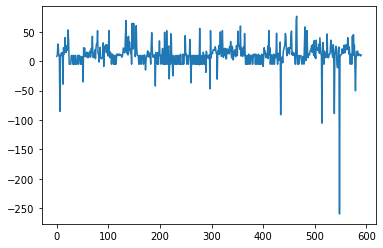

In [ ]:
#plot the predictions for validation set
plt.plot(y_true, label='Valid')
plt.show()

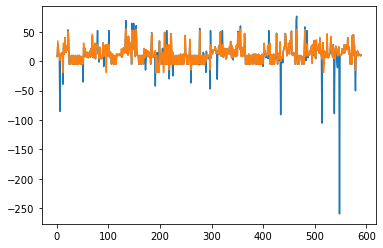

In [ ]:
plt.plot(y_true, label='Valid')
plt.plot(y_pred, label='Prediction')
plt.show()

# Auto-ARIMA

Splitting the data for training and testing (80% 20%)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AdvanceML/final_data.csv',sep = ',')

In [ ]:
trainSamples=df.sample(frac=0.8,random_state=200) #random state is a seed value
testsamples=df.drop(trainSamples.index)

There are two assumptions of Auto Arima
1.   The series should be univariate
2.   The series should be stationary 

In [ ]:
print(trainSamples.shape)
print(testsamples.shape)

(2366, 13)
(591, 13)


Satisfying first assumtion: Making the series univariate

In [ ]:
X = trainSamples['Irrigation_Required']
y = testsamples['Irrigation_Required']

In [ ]:
print("Training Shape: ",X.shape)
print("Testing Shape: ",y.shape)

Training Shape:  (2366,)
Testing Shape:  (591,)


Satisfying the second assumption: Testing if the series is stationary or not

In [ ]:
#We are performing the test that wether the series is stationary or not
#The null hypothesis of the test is that the time series is not stationary, while 
#the alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.
print("p-value:", adfuller(X)[1])

p-value: 0.0


The p-value is less than significance interval i-e 0.05, so we tested that the series is stationary

***Training Auto Arima***

In [ ]:
autoarima_model = pmd.auto_arima(X, start_p=1, start_q=1,test="adf",trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=21114.039, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=21110.192, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=21112.108, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=21112.102, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21620.088, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.914 seconds


***Testing Auto Arima***

In [ ]:
testsamples['ARIMA_prediction'] = autoarima_model.predict(len(testsamples.Irrigation_Required))

In [ ]:
y_true, y_pred = np.array(testsamples.Irrigation_Required), np.array(testsamples.ARIMA_prediction)

Mean Absolute Percentage Error (MAPE)

In [ ]:
MAPE = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE

96.54265509648293

Corelation Cofficient

In [ ]:
y_pred

array([10.28841194, 10.28841194, 10.28841194, 10.28841194, 10.28841194,
       10.28841194, 10.28841194, 10.28841194, 10.28841194, 10.28841194,
       10.28841194, 10.28841194, 10.28841194, 10.28841194, 10.28841194,
       10.28841194, 10.28841194, 10.28841194, 10.28841194, 10.28841194,
       10.28841194, 10.28841194, 10.28841194, 10.28841194, 10.28841194,
       10.28841194, 10.28841194, 10.28841194, 10.28841194, 10.28841194,
       10.28841194, 10.28841194, 10.28841194, 10.28841194, 10.28841194,
       10.28841194, 10.28841194, 10.28841194, 10.28841194, 10.28841194,
       10.28841194, 10.28841194, 10.28841194, 10.28841194, 10.28841194,
       10.28841194, 10.28841194, 10.28841194, 10.28841194, 10.28841194,
       10.28841194, 10.28841194, 10.28841194, 10.28841194, 10.28841194,
       10.28841194, 10.28841194, 10.28841194, 10.28841194, 10.28841194,
       10.28841194, 10.28841194, 10.28841194, 10.28841194, 10.28841194,
       10.28841194, 10.28841194, 10.28841194, 10.28841194, 10.28

In [ ]:
r2_score(y_true, y_pred)

-0.0008980280561148302

Visualizing the results

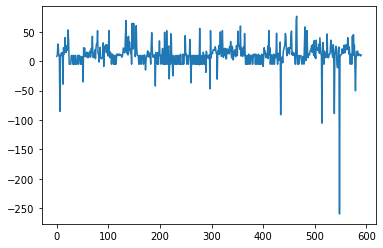

In [ ]:
#Plotting actual datapoints
plt.plot(y_true, label='Valid')
plt.show()

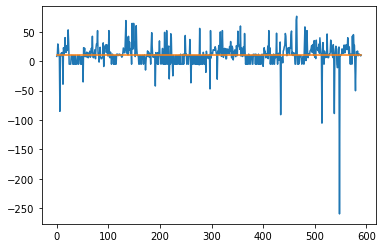

In [ ]:
#plotting predicted datapoints
plt.plot(y_true, label='Valid')
plt.plot(y_pred, label='Prediction')
plt.show()